In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [36]:
main_directory_original_data = '../celeba/original-data/'
main_directory_artificial_data = '../celeba/artificial-augmentation/'
image_size = (64, 64)
batch_size = 128
labels = ['female', 'male']

In [37]:
train_files = os.path.join(main_directory_original_data, 'train')

classes = os.listdir(train_files)

train_images, labels_train = [], []

for class_ in classes:
    file_class = os.path.join(train_files, class_)
    images_class = [os.path.join(file_class, img) for img in os.listdir(file_class)]
    labels_class = [class_] * len(images_class)
    train_images.extend(images_class)
    labels_train.extend(labels_class)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, labels_train, test_size = 0.1, stratify = labels_train,
    random_state = 42)

train_images = [s.replace('\\', '/') for s in train_images]
val_images = [s.replace('\\', '/') for s in val_images]

In [38]:
train_dataframe = pd.DataFrame({
    'images': train_images, 'labels': train_labels
})

val_dataframe = pd.DataFrame({
    'images': val_images, 'labels': val_labels
})

In [39]:
train_dataframe['labels'].value_counts()

labels
female    95171
male      68934
Name: count, dtype: int64

In [40]:
val_dataframe['labels'].value_counts()

labels
female    10575
male       7659
Name: count, dtype: int64

In [41]:
datagen = ImageDataGenerator(rescale = 1./255)

In [42]:
train_gen = datagen.flow_from_dataframe(
    dataframe = train_dataframe,
    x_col = 'images', y_col = 'labels',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True, seed = 42
)

Found 164105 validated image filenames belonging to 2 classes.


In [43]:
val_gen = datagen.flow_from_dataframe(
    dataframe = val_dataframe,
    x_col = 'images', y_col = 'labels',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True, seed = 42
)

Found 18234 validated image filenames belonging to 2 classes.


In [44]:
test_gen_original_data = datagen.flow_from_directory(
    directory = main_directory_original_data + 'test',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True, seed = 42
)

Found 20260 images belonging to 2 classes.


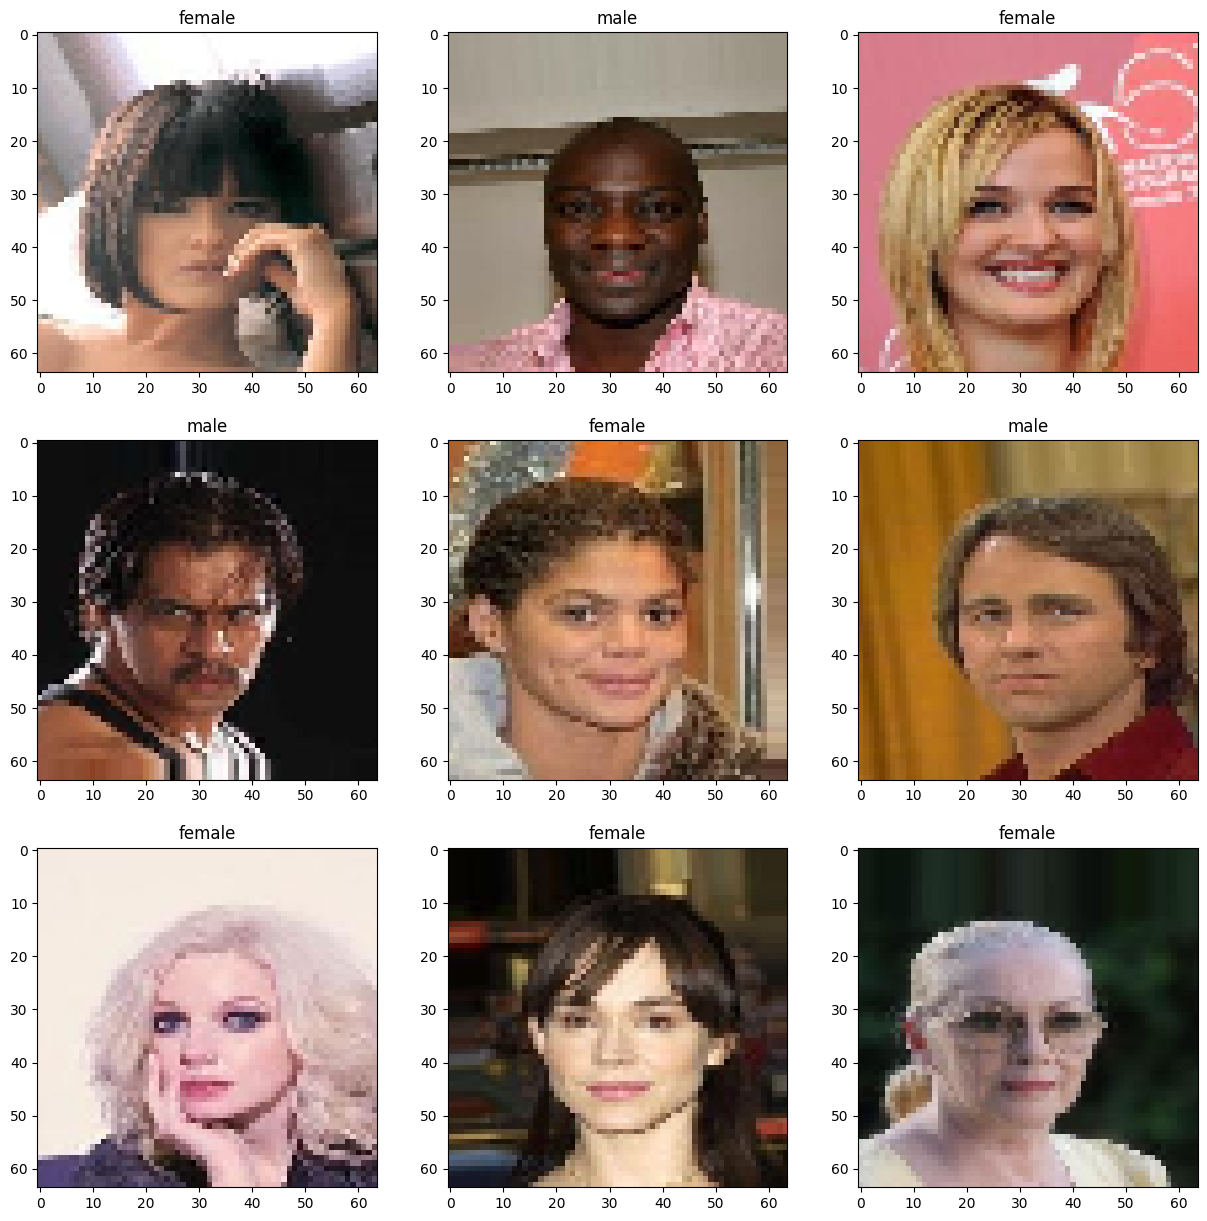

In [45]:
(x, y) = train_gen[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(labels[int(str(list(y[count]).index(1)))])
    axs[i,j].imshow(x[count])
    count += 1

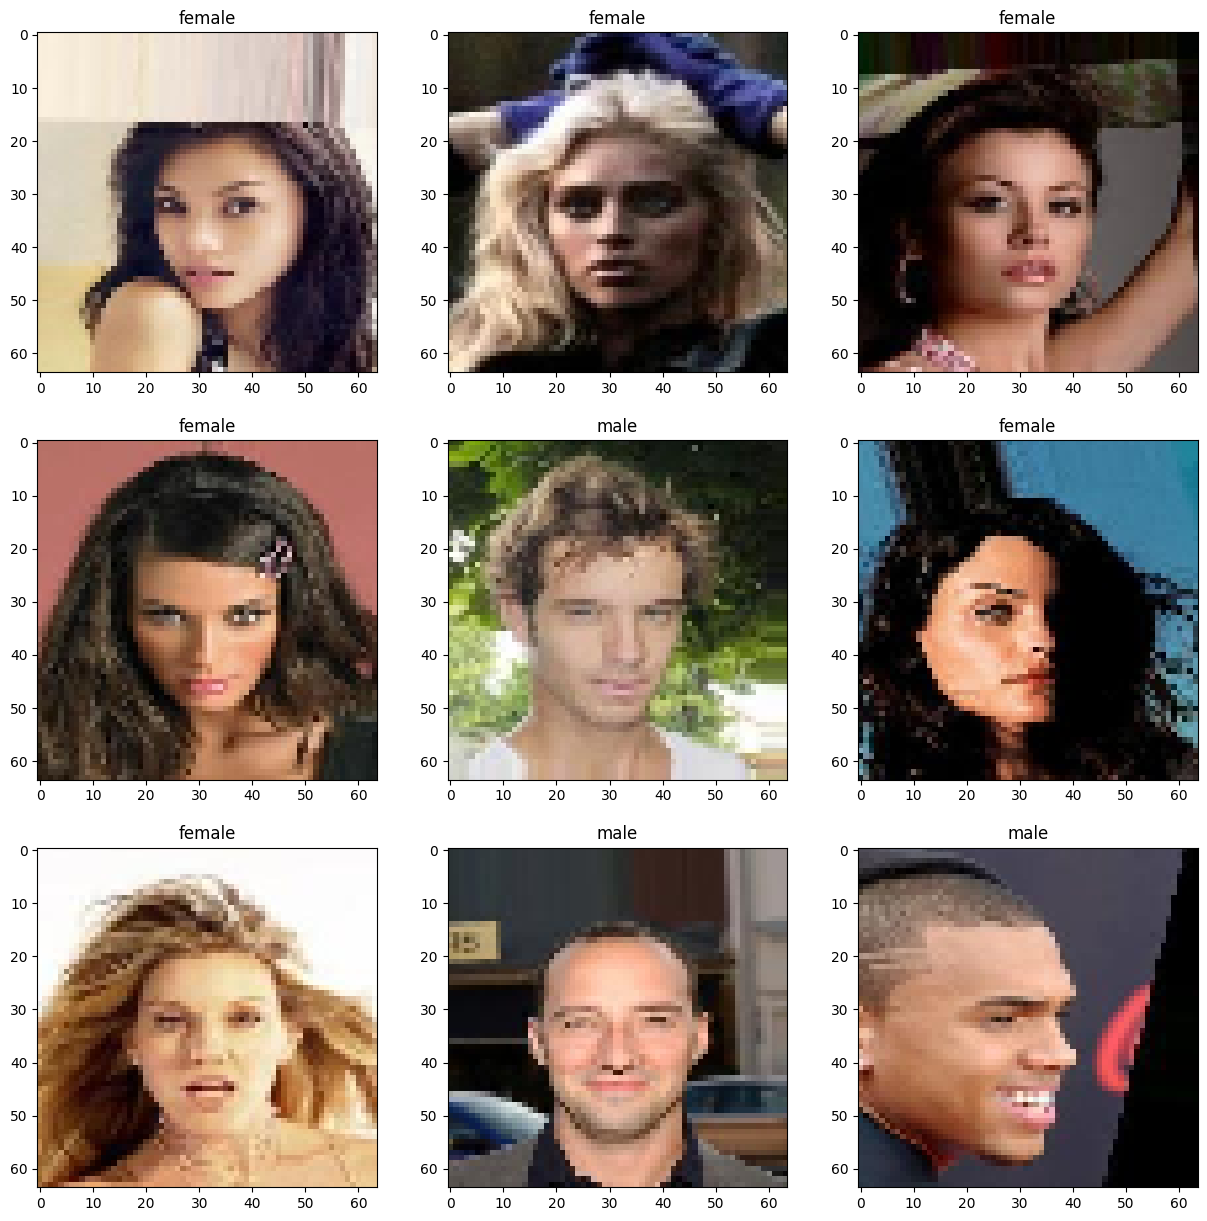

In [46]:
(x, y) = val_gen[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(labels[int(str(list(y[count]).index(1)))])
    axs[i,j].imshow(x[count])
    count += 1

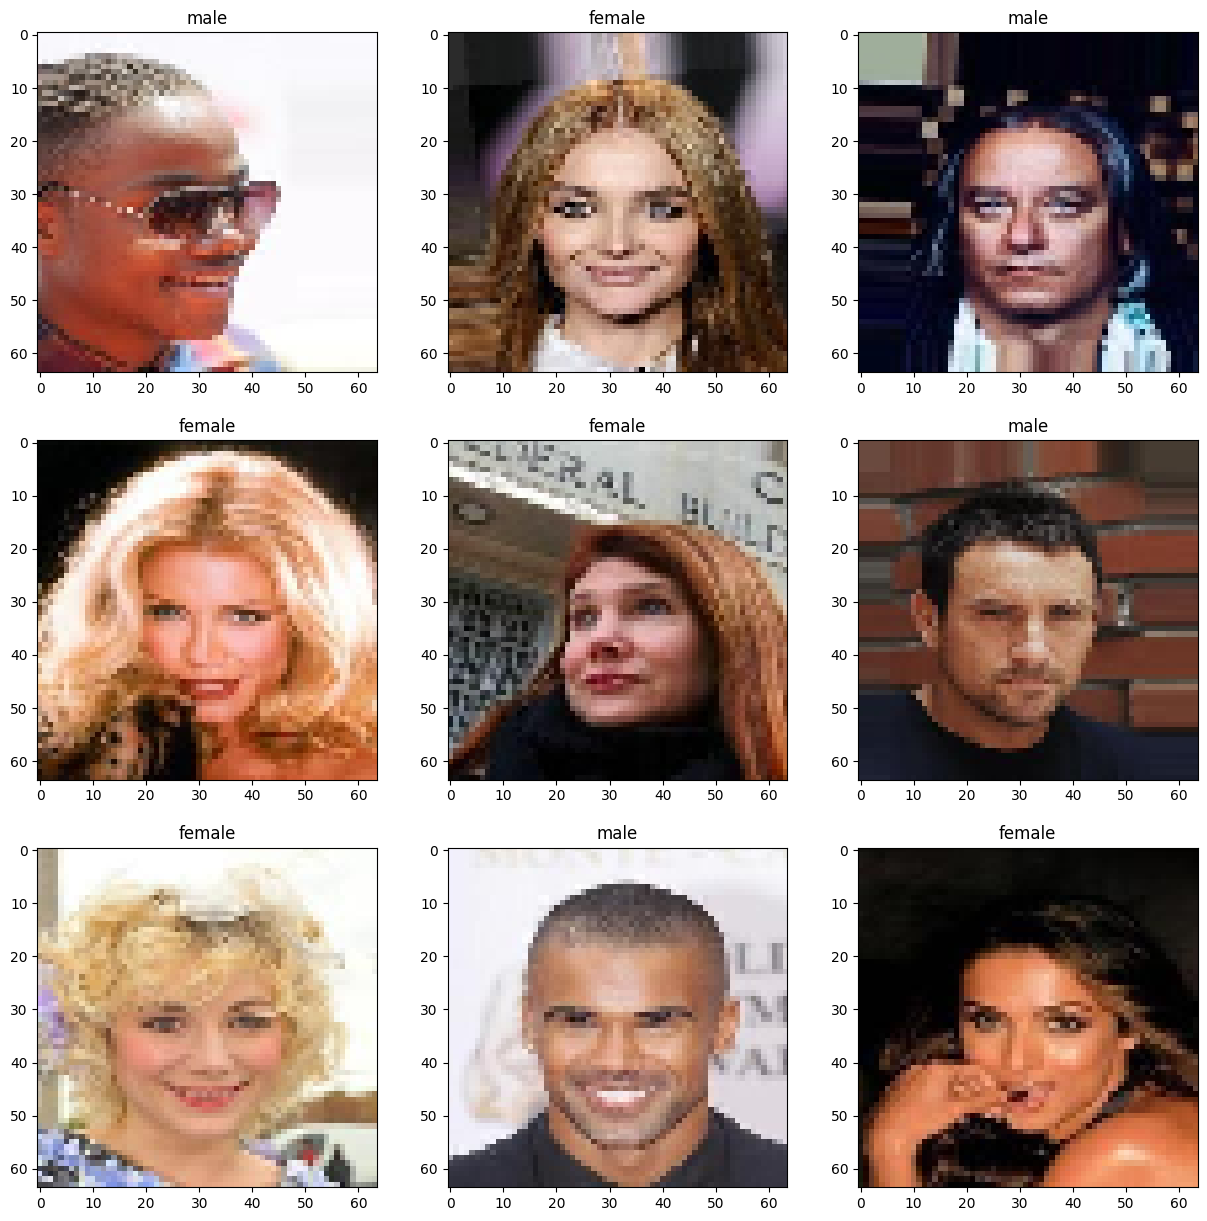

In [47]:
(x, y) = test_gen_original_data[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(labels[int(str(list(y[count]).index(1)))])
    axs[i,j].imshow(x[count])
    count += 1

In [48]:
def build_model(input_shape, n_outputs):

    network = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), 
                           activation = 'relu', 
                           input_shape = input_shape),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), 
                           activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), 
                           activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 512, activation = 'relu'),
    tf.keras.layers.Dropout(rate = 0.50),  
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dropout(rate = 0.50),
    tf.keras.layers.Dense(units = n_outputs, 
                          activation = 'softmax')])

    return network

model = build_model((64, 64, 3), len(classes))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
              metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 15376)             0         


                                                                 
 dense_4 (Dense)             (None, 64)                984128    
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 984,706
Trainable params: 984,706
Non-trainable params: 0
_________________________________________________________________


In [49]:
epochs = 1

for epoch in range(epochs):
    
    model.fit(train_gen,
              steps_per_epoch = np.ceil((len(train_dataframe) / batch_size)),
              validation_data = val_gen,
              epochs = 1, verbose = 1)
    
    number_of_examples = len(train_gen.filenames)
    number_of_generator_calls = np.ceil(number_of_examples / batch_size)
    
    train_labels_data = []

    for i in range(0,int(number_of_generator_calls)):
        train_labels_data.extend(np.array(train_gen[i][1]))

    train_labels_data = np.argmax(train_labels_data, axis = 1)

    y_train_pred = model.predict(train_gen)
    y_train_pred_classes = np.argmax(y_train_pred, axis = 1)
    
    acuracy_train = accuracy_score(train_labels_data, y_train_pred_classes)
    precision_train = precision_score(train_labels_data, y_train_pred_classes, 
                                      average = 'macro')
    recall_train = recall_score(train_labels_data, y_train_pred_classes, 
                                average = 'macro')
    f1_score_train = f1_score(train_labels_data, y_train_pred_classes, 
                              average = 'macro')
    
    number_of_examples = len(val_gen.filenames)
    number_of_generator_calls = np.ceil(number_of_examples / batch_size)

    val_labels_data = []

    for i in range(0,int(number_of_generator_calls)):
        val_labels_data.extend(np.array(val_gen[i][1]))

    val_labels_data = np.argmax(val_labels_data, axis = 1)

    y_val_pred = model.predict(val_gen)
    y_val_pred_classes = np.argmax(y_val_pred, axis = 1)
    
    acuracy_val = accuracy_score(val_labels_data, y_val_pred_classes)
    precision_val = precision_score(val_labels_data, y_val_pred_classes, 
                                    average = 'macro')
    recall_val = recall_score(val_labels_data, y_val_pred_classes, 
                              average = 'macro')
    f1_score_val = f1_score(val_labels_data, y_val_pred_classes, 
                            average = 'macro')

    print(f'\n=== Epoch {epoch + 1} ===')
    print(f'Accuracy (train): {acuracy_train:.4f}')
    print(f'Precision (train): {precision_train:.4f}')
    print(f'Recall (train): {recall_train:.4f}')
    print(f'F1-score (train): {f1_score_train:.4f}')
    print(f'Accuracy (validation): {acuracy_val:.4f}')
    print(f'Precision (validation): {precision_val:.4f}')
    print(f'Recall (validation): {recall_val:.4f}')
    print(f'F1-score (validation): {f1_score_val:.4f}')
    print('---')

143/143 [==============================] - 7s 49ms/step

=== Epoch 1 ===
Accuracy (train): 0.9531
Precision (train): 0.9508
Recall (train): 0.9534
F1-score (train): 0.9520
Accuracy (validation): 0.9513
Precision (validation): 0.9492
Recall (validation): 0.9512
F1-score (validation): 0.9501
---


In [50]:
number_of_examples = len(test_gen_original_data.filenames)
number_of_generator_calls = np.ceil(number_of_examples / batch_size)

test_labels_original_data = []

for i in range(0,int(number_of_generator_calls)):
    test_labels_original_data.extend(np.array(test_gen_original_data[i][1]))

test_labels_original_data = np.argmax(test_labels_original_data, axis = 1)

y_test_pred_original_data = model.predict(test_gen_original_data)
y_test_pred_classes_original_data = np.argmax(y_test_pred_original_data, axis = 1)

159/159 [==============================] - 8s 48ms/step


In [51]:
acuracy_test_original_data = accuracy_score(test_labels_original_data, y_test_pred_classes_original_data)
precision_test_original_data = precision_score(test_labels_original_data, y_test_pred_classes_original_data, 
                                               average = 'macro')
recall_test_original_data = recall_score(test_labels_original_data, y_test_pred_classes_original_data, 
                                         average = 'macro')
f1_score_test_original_Data = f1_score(test_labels_original_data, y_test_pred_classes_original_data, 
                                       average = 'macro')

print(f'Accuracy (test original data): {acuracy_test_original_data:.4f}')
print(f'Precision (test original data): {precision_test_original_data:.4f}')
print(f'Recall (test original data): {recall_test_original_data:.4f}')
print(f'F1-score (test original data): {f1_score_test_original_Data:.4f}')

Accuracy (test original data): 0.9495
Precision (test original data): 0.9452
Recall (test original data): 0.9489
F1-score (test original data): 0.9470
